# Fig_19-20 MCMC posterior draws 

Code taken from ../code2/Read_IDL.ipynb 

In [1]:
import linmix
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os
import scipy
import matplotlib.lines as mlines
import seaborn as sns 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



 
../IDL/190807_celerite_MI_Z2_SDSS_M10_good/
3 mean C= 0.12546597145850893
3 mean D= 0.10362488999283885
 
../IDL/190807_celerite_MI_Z2_SDSS-PS1_M10_good/
3 mean C= 0.11757886788175752
3 mean D= 0.11753837793751368
Saving as  Fig_19-20_MI_Z2_SF_comp.pdf
 
../IDL/190807_celerite_MI_Z2_SDSS_M10_good/
3 mean C= 0.04152768292163572
3 mean D= 0.1269360017627791
 
../IDL/190807_celerite_MI_Z2_SDSS-PS1_M10_good/
3 mean C= 0.0353037167484119
3 mean D= 0.14087363878183895
Saving as  Fig_19-20_MI_Z2_tau_comp.pdf


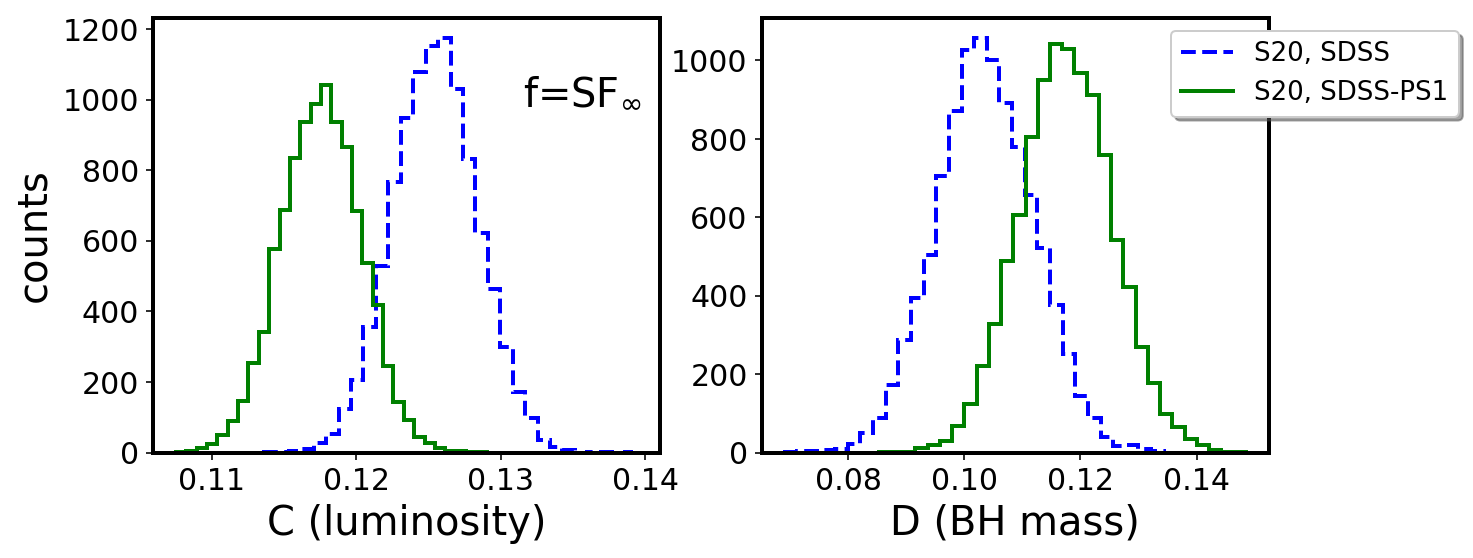

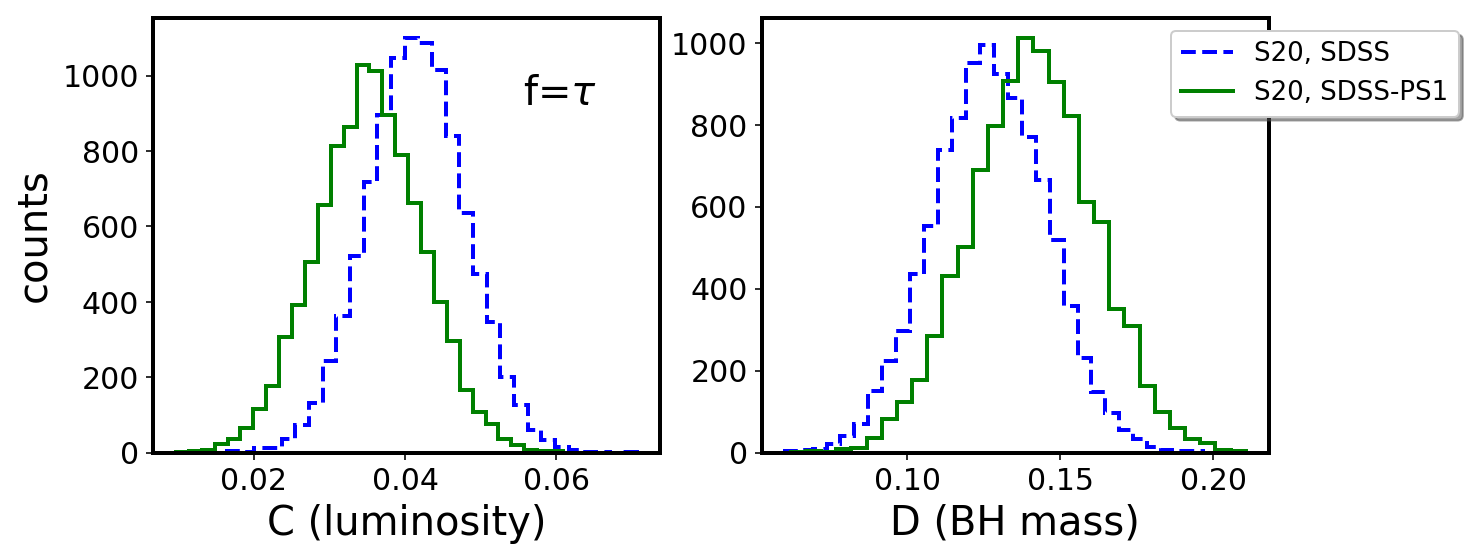

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
band = 3 

 # 'tau'# 'SF'#'tau' #  'SF' # \tau

length = 18
results = {'f': np.zeros(length).astype(str), 
           'source':np.zeros(length).astype(str),
           'A':np.zeros(length).astype(float), 
           'A_unc':np.zeros(length).astype(float),
           'B':np.zeros(length).astype(float), 
           'B_unc':np.zeros(length).astype(float),
           'C':np.zeros(length).astype(float),  
           'C_unc':np.zeros(length).astype(float), 
           'D':np.zeros(length).astype(float) , 
           'D_unc':np.zeros(length).astype(float)
          }

catalog = 'MI_Z2'# 'M_i_corr' #  # 'M_i_corr' # 'M_i_corr  
pre = 'Shen2011'# 'Shen2008'# 
# date = '190228'
# ds = ['../IDL/M10_line5_ACD_'+catalog+'/',
# '../IDL/'+date+'_celerite_'+catalog+'_SDSS/',
# '../IDL/'+date+'_celerite_'+catalog+'_SDSS-PS1/']
date = '190807'  # cleaned_NEW  light curves 
# date = '190930' # raw light curves 

sup = '1'# '1' # good,  '2' : all 
survey = 'SDSS'
if sup is '1':
    title  = ''#'v1: 6371 quasars that fulfill M10 selection'
    ds = [#'../IDL/190729_M10_'+catalog+'_good/', # 6371 / 6871  
        #  '../IDL/190228_celerite_'+catalog+'_SDSS/',  # 4968  of 6444 , the inner join ... 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_M10_good/',  # 6371 / 8516 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'-PS1_M10_good/', # 6371 / 8516
  #   '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'-PS1_M10_good_err/', # 6371 / 8516 ,
   #       using LOGBH_ERR rather than 0.2   as the homoscedastic error ..    
#     '../IDL/'+date+'_celerite_'+catalog+'_SDSS_subset/' , # 3567 / 4968 in 190228 that were in M10
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S0/', # 3000 / 6371 
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S1/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S2/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S3/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S4/', # 3000 / 6371
   #  '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'_S5/', # 3000 / 6371
         ]
if sup is '2':
    title = 'v2: 8516 SDSS-PS1 quasars with Celerite results'
    ds = [#'../IDL/190729_M10_'+catalog+'/', # 6371 / 6871 
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'/', # all 8516
     '../IDL/'+date+'_celerite_'+catalog+'_'+survey+'-PS1/'# all 8516
         ]


# matched to the 6871 M10 r-band that  fulfill M10 selection criteria...

colors= ['blue','green', 'orange',  'red', 'magenta', 'purple', 'cyan']
ls = ['dashed' ,'solid', 'dashed', 'dotted', 'dashed',  'dotted', 'dotted']
labels = [#'M10, SDSS 6371',
         # 'S19, SDSS 4968',
        # 'S19, SDSS raw',
         'S20, SDSS',
         'S20, SDSS-PS1',
        #'S19, SDSS-PS1, err'
#          'S19, '+survey+' SS 6371',
#          'S19 '+survey+' S0: 3000 / 6371',  # three random subsets of M10 good set 
#          'S19 '+survey+' S1: 3000 / 6371', 
#          'S19 '+survey+' S2: 3000 / 6371',
#          'S19 '+survey+' S3: 3000 / 6371',
#          'S19 '+survey+' S4: 3000 / 6371',
#          'S19 '+survey+' S5: 3000 / 6371',
         ]
# labels = ['M10, 6871 QSO, SDSS', 'S19, 6371 QSO, SDSS ', 
#           'S19, 6371 QSO, SDSS-PS1 ',
#           'S19, 8516 QSO, SDSS',
#           'S19, 8516 QSO, SDSS-PS1'
#          ]

# the five-band average , using 0.2 as MBH error 
M10_ugriz = {'SF' : {'C':0.131, 'Cerr': 0.008, 'D':0.18, 'Derr':0.03},
            'tau': {'C':0.03, 'Cerr': 0.04, 'D':0.21 , 'Derr': 0.07}
            }
k = 0 
for par in ['SF','tau' ] : 
    f = 'coeff'+par+'o_mcmc2_'+str(band)+'_E0a.fits'
    lw=2
    A=[]; C=[]; D=[]
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    i = 0 
    ax_legend_handles = [] 
    nbins = 30
    for d in ds : 
        results['f'][k] = par
        results['source'][k] = labels[i] 
        
        print(' ')
        print(d)
        post = Table.read(d+f, format='fits')
        
        
        results['A'][k] = np.mean(post['ALPHA'])
        results['A_unc'][k] = np.std(post['ALPHA'])
        
        if par is 'tau':
            results['B'][k] = 0.17
            results['B_unc'][k] = 0.02
        if par is 'SF' : 
            results['B'][k] = -0.479
            results['B_unc'][k] = 0.005
        
        results['C'][k] = np.mean(post['BETA'][:,0])
        results['C_unc'][k] = np.std(post['BETA'][:,0])
        
        results['D'][k] = np.mean(post['BETA'][:,1])
        results['D_unc'][k] = np.std(post['BETA'][:,1])
        
        

        ax[0].hist(post['BETA'][:,0],histtype='step',color=colors[i],lw= lw,
                   ls=ls[i],bins=nbins, )#density=True)
        
        print(band, 'mean C=', np.mean(post['BETA'][:,0]))
        #results['']
        #C.append(np.mean(post['BETA'][:,0]))

        ax[1].hist(post['BETA'][:,1],histtype='step',color=colors[i],lw=lw ,
                   ls=ls[i],bins=nbins,)# density=True)
        print(band, 'mean D=', np.mean(post['BETA'][:,1]))
        #D.append(np.mean(post['BETA'][:,1]))

        line = mlines.Line2D([], [],  color=colors[i], label=labels[i],lw=2,
                            ls=ls[i])
        ax_legend_handles.append(line)
        i += 1 
        k += 1 
        

#     loc = M10_ugriz[par]['C'] ; sigma = M10_ugriz[par]['Cerr']
#     ax[0].axvline(loc)
#     ax[0].axvspan(loc-sigma, loc+sigma,alpha=0.3)
    
#     loc = M10_ugriz[par]['D'] ; sigma = M10_ugriz[par]['Derr']
#     ax[1].axvline(loc)
#     ax[1].axvspan(loc-sigma, loc+sigma,alpha=0.3)
    
    
    # 
    ax[1].legend(loc='upper right', handles = ax_legend_handles,
                 bbox_to_anchor=(1.4, 1.0),
                 ncol=1, fancybox=True, shadow=True, fontsize=13 )

    ax[0].set_xlabel('C (luminosity)')
    ax[1].set_xlabel('D (BH mass)')
    ax[0].set_ylabel('counts')
    if par is 'SF':
        func = par+r'$_{\infty}$'
    if par is 'tau':
        func = r'$\tau$'

    ax[0].text(0.73,0.8, 'f='+func,transform=ax[0].transAxes, fontsize=20)
    #fig.suptitle(title, fontsize=18)
    figname  = 'Fig_19-20_'+catalog+'_'+par+'_comp.pdf'
    print('Saving as ', figname)
    plt.savefig(figname, bbox_inches='tight',
               dpi=100)